In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
noise_sigma = 5 # set this to lower for more noisy train data

## Generate Toy 2D Data

(-1.5, 1.5)

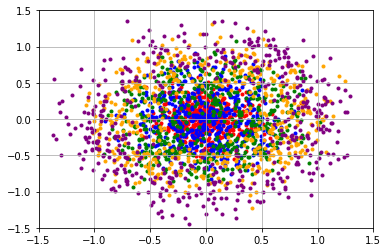

In [4]:
# five concentric circles
def generate_data(n_samples_per, device, sigma=20.):
    
    radii = [0.2, 0.4, 0.6, 0.8, 1.0]
    xs = []
    ys = []
    labels = []
    for label in range(len(radii)):
        radius = radii[label] + torch.randn(n_samples_per, device=device) / sigma
        angles = torch.rand(n_samples_per, device=device) * 2. * 3.1415926
        x = torch.cos(angles) * radius
        y = torch.sin(angles) * radius
        xs.append(x)
        ys.append(y)
        labels.append(torch.ones(n_samples_per, device=device)*label)
    xs = torch.cat(xs)
    ys = torch.cat(ys)
    labels = torch.cat(labels)
    return torch.stack((xs, ys)).T, labels

data, labels = generate_data(500, 'cpu', sigma=noise_sigma)
labels = np.array(labels.int())
xs = data.T[0].numpy()
ys = data.T[1].numpy()

cdict = {0: 'red', 1: 'blue', 2: 'green', 3:'orange', 4:'purple'}

for label in np.unique(labels):
    ix = np.where(labels == label)
    plt.scatter(xs[ix], ys[ix], marker = '.', c=cdict[label])
    
plt.grid()
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
# plt.title('Data')

In [5]:
from torch import nn
device = 'cuda'
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(2,100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100,100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100,2)
        )
    def forward(self, input):
        return self.main(input)
    
from tqdm import tqdm
import torch.nn.functional as F
from pytorch_metric_learning import losses

def margin_contrastive(scores, w, pos_margins=0.9, neg_margins=0.6):
    '''pos_margins and neg_margins must be column vectors or scalars
    '''
    L_pos = F.relu(pos_margins - scores) * w
    L_neg = F.relu(scores - neg_margins) * (1. - w)
    
    if (L_pos > 0.).sum() < 1e-5:
        l_p = torch.tensor(0.)
    else:
        l_p = L_pos.sum() / (L_pos > 0.).sum()
    if (L_neg > 0.).sum() < 1e-5:
        l_n = torch.tensor(0.)
    else:
        l_n = L_neg.sum() / (L_neg > 0.).sum()
        
    return l_p + l_n

## 1. Standard Contrastive Loss

In [6]:
net = MLP().to(device)
criterion = losses.ContrastiveLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, weight_decay=1e-5)
labels = torch.tensor(labels)
loss_list = []
for _ in tqdm(range(20000)):
    # sample batch
    data, labels = generate_data(4, device, sigma=noise_sigma)
    f = F.normalize(net(data))
    loss = criterion(f, labels)
    optimizer.zero_grad()
    loss.backward()
    loss_list.append(loss.item())
    optimizer.step()

100%|██████████| 20000/20000 [01:02<00:00, 319.09it/s]


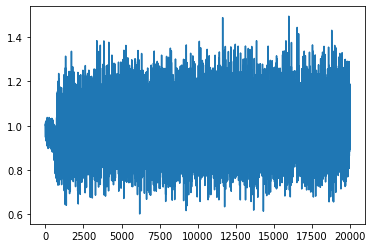

In [7]:
plt.plot(loss_list)

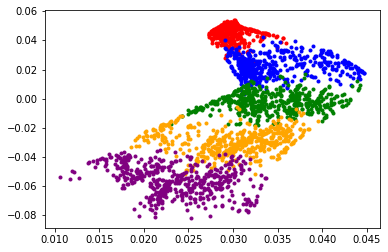

In [8]:
data, labels = generate_data(500, device)
f = net(data).detach().T.cpu().numpy()
labels = labels.cpu()
for label in labels.unique().cpu():
    ix = np.where(labels == label.item())
    plt.scatter(f[0][ix], f[1][ix], marker = '.', c=cdict[label.item()])

## 2. Nk Mask Loss (L_1 in Paper)

In [9]:
class GreaterThan(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return (x >= y).float()
    @staticmethod
    def backward(ctx, grad_output):
        x,y = ctx.saved_tensors
        g = 10.
        return grad_output * g, - grad_output * g
    
def get_jaccard_similarity(w, scores, k):
    # features has been normalized before this function
    # D is ||u-v||^2 = 2 - 2<u,v>
    D = 2. - 2. * scores  # Euclidedan, assume features are L2 normalized
    D = D.clamp(min=0.)   # for stability
    vk, ik = (-D).topk(k)                  # get k closest neighbors
    
    Nk_mask = GreaterThan.apply(-D + 0.05, vk[:,-1:].detach())
    return Nk_mask

def contrastive_jaccard(scores, w, k):
    js = get_jaccard_similarity(w, scores, k=k)
    I_neg = torch.ones_like(js) - torch.eye(js.shape[0], device=js.device)
    l1 = ((1. - js).square() * w * I_neg)     # positive pairs 
    l2 = (js.square() * (1. - w) * I_neg)  # negative pairs
    return (l1.sum() + l2.sum()) / js.shape[0] / js.shape[0]


In [10]:
net = MLP().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.00004, weight_decay=1e-4)
labels = torch.tensor(labels)
loss_list = []
for _ in tqdm(range(20000)):
    # sample batch
    data, labels = generate_data(4, device, sigma=noise_sigma)
    f = F.normalize(net(data))
    w = (labels == labels.unsqueeze(0).T).float()
    loss = contrastive_jaccard(f@f.T, w, k=4)
    optimizer.zero_grad()
    loss.backward()
    loss_list.append(loss.item())
    optimizer.step()

<ipython-input-10-d357d8e55770>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
100%|██████████| 20000/20000 [00:41<00:00, 485.78it/s]


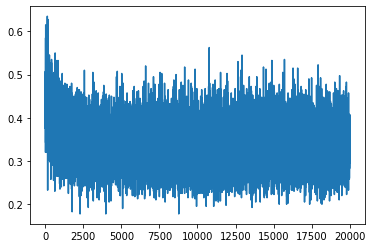

In [11]:
plt.plot(loss_list)

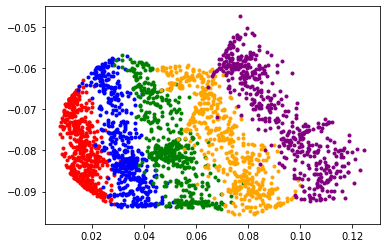

In [12]:
data, labels = generate_data(500, device)
f = net(data).detach().T.cpu().numpy()
labels = labels.cpu()
for label in labels.unique().cpu():
    ix = np.where(labels == label.item())
    plt.scatter(f[0][ix], f[1][ix], marker = '.', c=cdict[label.item()])